## Classifying JWST-HST galaxy mergers with Vision Transformers (ViT)

In this notebook we implement a **Vision Transformer (ViT)** for the problem of classifying whether a galaxy has undergone a merger.


- Install `TensorFlow` addons

In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.8 MB/s eta 0:00:00


- Install basic packages

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# sklearn (for machine learning)
from sklearn.model_selection import train_test_split
from sklearn import metrics

# ==============================================
# ==============================================
# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

### Download and prepare the data

In [ ]:
# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

In [ ]:
# Version to download
version = 'pristine'


#%%time
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

In [ ]:
X = np.asarray(hdu[0].data).astype('float32')
y = np.asarray(hdu[1].data).astype('float32')

# Flip axes to have a channels-last format
X_new = np.moveaxis(X,1,3)#/np.max(X)

In [ ]:
print(np.shape(X_new))
print(np.max(X_new))

(15426, 75, 75, 3)
4554.6943


Split into merging vs non-merging galaxies

In [ ]:
X_mergers = X_new[y==1.0]
X_nonmergers = X_new[y==0.0]

print(np.shape(X_mergers))
print(np.shape(X_nonmergers))

(8120, 75, 75, 3)
(7306, 75, 75, 3)


**Plot a subset of mergers**

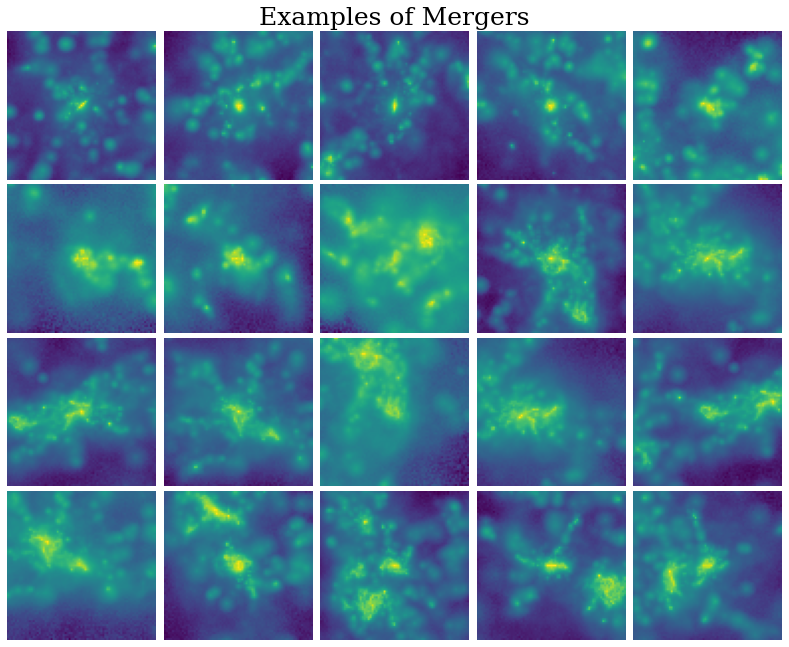

In [ ]:
# Plot them
n_rows = 4
n_cols = 5


plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Examples of Mergers",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(np.log10(X_mergers[i,:,:,0]))
    plt.axis('off')


plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.show()



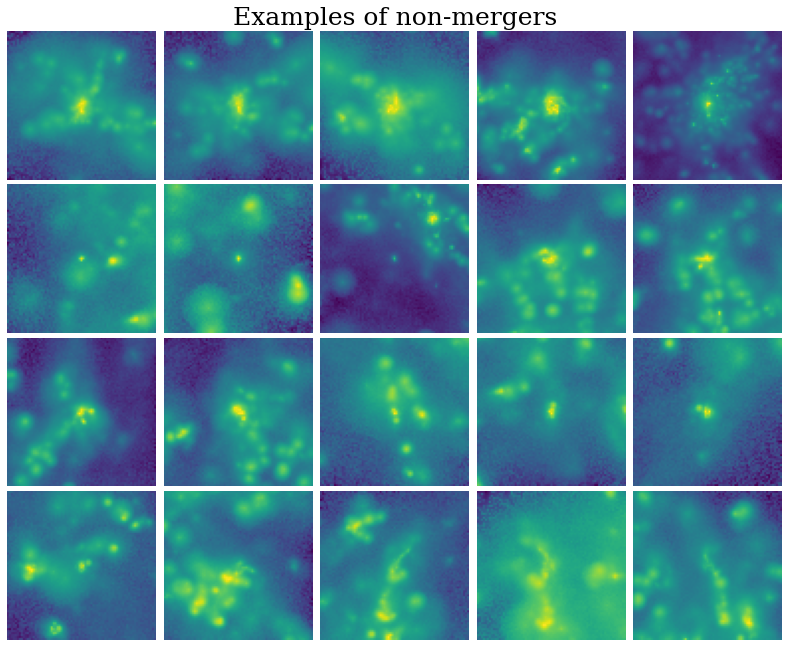

In [ ]:
# Plot them
n_rows = 4
n_cols = 5


plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Examples of non-mergers",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(np.log10(X_nonmergers[i,:,:,0]))
    plt.axis('off')


plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.show()

### Log transformation and split into training/test sets

First I transform the map using a log-transformation

In [ ]:
X_log = np.log10(X_new+1e-5)
print(np.min(X_log),np.max(X_log))

-5.0 3.6584592


In [ ]:
# Split into training-test sets
# =============================
# Random state
random_state = 42

# First split off 30% of the data for validation+testing
X_train, X_test, y_train, y_test = train_test_split(X_log, y, test_size=0.3, random_state=random_state, shuffle=True)

# Length of 
print(len(y_train),len(y_test))

10798 4628


In [ ]:
num_classes = 2
input_shape = (75, 75, 3)

### **Train a ViT**

#### Configure Hyperparameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 128
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

### Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02)
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

### Implement multilayer perceptron (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### Implement patch creation as a layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Let's display patches for a randomly selected image

Image size: 72 X 72
Patch size: 8 X 8
Patches per image: 81
Elements per patch: 192


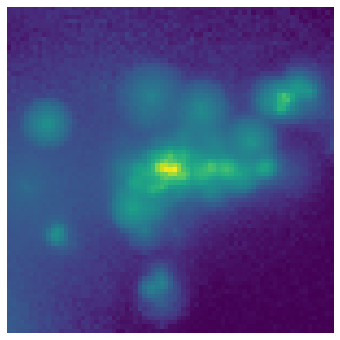

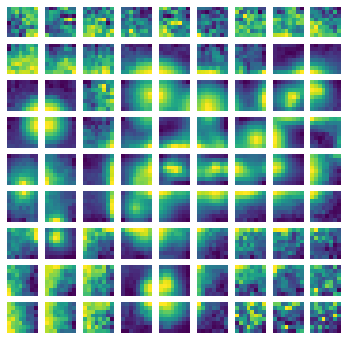

In [ ]:
plt.figure(figsize=(6, 6))
img_id = np.random.choice(range(X_train.shape[0]))
image = X_train[img_id]
plt.imshow(image[:,:,0])
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(6, 6))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy()[:,:,0])
    plt.axis("off")

### Implement the patch encoding layer

The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### Build ViT model

In [ ]:
tf.keras.backend.clear_session()

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1, activation='sigmoid')(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

### Complile and train the model

In [ ]:
model = create_vit_classifier()
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1)
model.compile(
      optimizer=optimizer,
      loss= 'binary_crossentropy',
      metrics=['accuracy'])

In [ ]:
n_epochs = 70
model.fit(x=X_train, y=y_train,
          epochs=n_epochs, batch_size=64,
          shuffle=True)#,
          #validation_data=(x_val,y_val))

Epoch 1/70


169/169 [==============================] - 70s 216ms/step - loss: 0.9978 - accuracy: 0.5460
Epoch 2/70
169/169 [==============================] - 37s 216ms/step - loss: 0.7561 - accuracy: 0.5790
Epoch 3/70
169/169 [==============================] - 37s 219ms/step - loss: 0.7165 - accuracy: 0.5887
Epoch 4/70
169/169 [==============================] - 37s 217ms/step - loss: 0.6835 - accuracy: 0.6079
Epoch 5/70
169/169 [==============================] - 37s 217ms/step - loss: 0.6691 - accuracy: 0.6156
Epoch 6/70
169/169 [==============================] - 37s 218ms/step - loss: 0.6467 - accuracy: 0.6378
Epoch 7/70
169/169 [==============================] - 37s 218ms/step - loss: 0.6388 - accuracy: 0.6443
Epoch 8/70
169/169 [==============================] - 37s 218ms/step - loss: 0.6266 - accuracy: 0.6528
Epoch 9/70
169/169 [==============================] - 37s 219ms/step - loss: 0.6190 - accuracy: 0.6619
Epoch 10/70
169/169 [==============================] - 37s 220ms/step - loss: 0.6097

KeyboardInterrupt: ignored

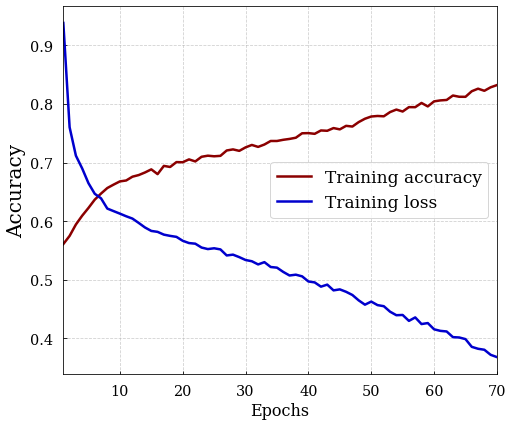

In [ ]:
Epochs = np.arange(1,n_epochs+1,1)
history_dict = model.history.history

train_acc = history_dict['accuracy']
#val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
#val_loss = history_dict['val_loss']
train_err = 1.0 - np.asarray(train_acc)
#val_err = 1.0 - np.asarray(val_acc)

# =====================================================================
# =====================================================================
plt.figure(figsize=(7.2, 6.0))

# Plot Accuracy
plt.plot(Epochs, train_acc, c = 'darkred',linewidth=2.5,label='Training accuracy')
#plt.plot(Epochs, val_acc , c = 'darkorange',linewidth=2.5,label='Validation accuracy')
# Plot Loss
plt.plot(Epochs, train_loss, c = 'mediumblue',linewidth=2.5,label='Training loss')
#plt.plot(Epochs, val_loss , c = 'dodgerblue',linewidth=2.5,label='Validation loss')

# =====================================================================
plt.grid(ls='--',alpha=0.6)
plt.xlabel('Epochs', fontsize=16);plt.ylabel('Accuracy',fontsize=20)
plt.xlim(1,n_epochs)
#plt.ylim(0.2,1)
plt.legend(frameon=True, loc='center right', fontsize=17)
plt.tick_params(axis='both', labelsize=14.5)


#plt.xlim(10,);plt.ylim(0,2)
plt.tight_layout()
plt.show()

In [ ]:
# Metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [ ]:
# Predict on test data 
scores = model.predict(X_test)

# What if we change that?
y_pred_ViT =  (scores > 0.5).astype("int32")[:,0]

145/145 [==============================] - 4s 22ms/step


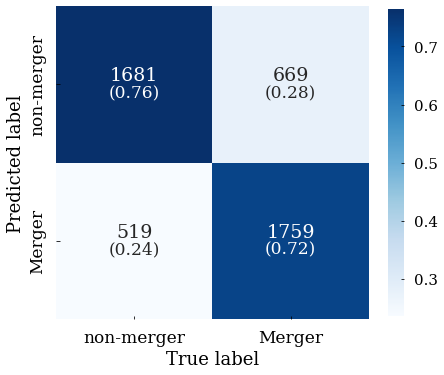

In [ ]:
# Get the confusion matrix for the Deep Learning
con_mat_DL = confusion_matrix(y_test, y_pred_ViT)

# Get annotations and normalized confusion matrix
a = con_mat_DL[0]/np.sum(con_mat_DL[0])
b = con_mat_DL[1]/np.sum(con_mat_DL[1])


con_mat_normalized = np.zeros([2,2])
con_mat_normalized[0] = a
con_mat_normalized[1] = b

# Annotations
an_1 = "("+"{:.2f}".format(a[0])+")"
an_2 = "("+"{:.2f}".format(a[1])+")"
an_3 = "("+"{:.2f}".format(b[0])+")"
an_4 = "("+"{:.2f}".format(b[1])+")"

annots = np.zeros([2,2],dtype='U6')

annots[0,0] = an_1;annots[0,1] = an_2
annots[1,0] = an_3;annots[1,1] = an_4

class_names = ['non-merger','Merger']
# ==============================================
# ==============================================


plt.figure(figsize = (7,6.0))
g =sns.heatmap(con_mat_DL.T, square = True, annot=True,annot_kws={'va':'bottom',"size": 19},fmt='.0f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)
sns.heatmap(con_mat_normalized.T, square=True, annot=annots.T, annot_kws={'va':'top',"size": 17},cmap='Blues',fmt='', cbar=True,
            cbar_kws={'shrink':0.94})
g.set_xticklabels(class_names, fontsize = 17)
g.set_yticklabels(class_names, fontsize = 17)

# Ticks for colorbar
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
# =========================================
# =========================================
plt.xlabel('True label',fontsize=18)
plt.ylabel('Predicted label',fontsize=18)
plt.show()

In [ ]:
print(accuracy_score(y_test,y_pred_ViT))
print(precision_score(y_test,y_pred_ViT))
print(recall_score(y_test,y_pred_ViT))

0.7932152117545376
0.7862981704943558
0.8319604612850082


## Transformers on a small dataset

In the academic paper Vision Transformer for Small-Size Datasets, the authors set out to tackle the problem of locality inductive bias in ViTs.

The main ideas are:

- Shifted Patch Tokenization
- Locality Self Attention

In [ ]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

In [ ]:
NUM_CLASSES = 2
INPUT_SHAPE = (75, 75, 3)

#### Configure the Hyperparameters

In [ ]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
IMAGE_SIZE = 72
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

#### Implement Shifted Patch Tokenization

In [ ]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

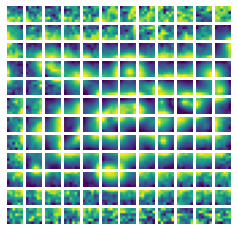

ORIGINAL


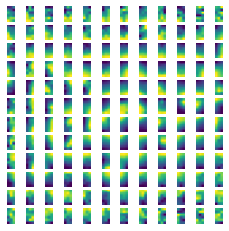

LEFT-UP


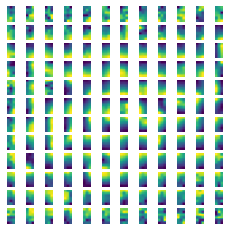

LEFT-DOWN


<ipython-input-45-596b5058021f>:40: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(image[..., 3 * index : 3 * index + 3,1])


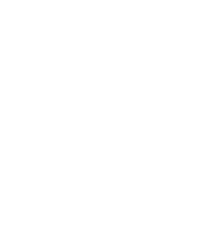

RIGHT-UP


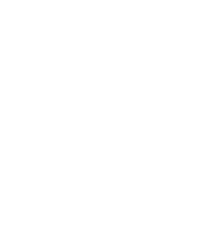

RIGHT-DOWN


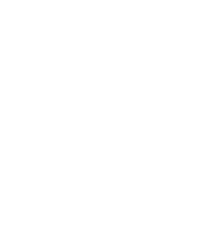

In [ ]:
# Get a random image from the training dataset
# and resize the image
img_id = np.random.choice(range(X_train.shape[0]))
image = X_train[img_id]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
        plt.imshow(image[:,:,0])
        plt.axis("off")
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

In [ ]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1, activation='sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
model = create_vit_classifier()
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1)
model.compile(
      optimizer=optimizer,
      loss= 'binary_crossentropy',
      metrics=['accuracy'])

In [ ]:
n_epochs = 10
model.fit(x=X_train, y=y_train,
          epochs=n_epochs, batch_size=64,
          shuffle=True)#,
          #validation_data=(x_val,y_val))

Epoch 1/10
169/169 [==============================] - 23s 136ms/step - loss: 0.3565 - accuracy: 0.8407
Epoch 2/10
169/169 [==============================] - 23s 134ms/step - loss: 0.3593 - accuracy: 0.8384
Epoch 3/10
169/169 [==============================] - 22s 133ms/step - loss: 0.3516 - accuracy: 0.8397
Epoch 4/10
169/169 [==============================] - 22s 133ms/step - loss: 0.3421 - accuracy: 0.8458
Epoch 5/10
169/169 [==============================] - 23s 133ms/step - loss: 0.3526 - accuracy: 0.8453
Epoch 6/10
169/169 [==============================] - 23s 134ms/step - loss: 0.3512 - accuracy: 0.8445
Epoch 7/10
169/169 [==============================] - 23s 133ms/step - loss: 0.3433 - accuracy: 0.8500
Epoch 8/10
169/169 [==============================] - 23s 135ms/step - loss: 0.3360 - accuracy: 0.8487
Epoch 9/10
169/169 [==============================] - 23s 133ms/step - loss: 0.3411 - accuracy: 0.8451
Epoch 10/10
169/169 [==============================] - 23s 133ms/step - l

In [ ]:
# Predict on test data 
scores = model.predict(X_test)

# What if we change that?
y_pred_ViT =  (scores > 0.5).astype("int32")[:,0]

145/145 [==============================] - 4s 24ms/step


In [ ]:
print(accuracy_score(y_test,y_pred_ViT))
print(precision_score(y_test,y_pred_ViT))
print(recall_score(y_test,y_pred_ViT))

0.8243301642178047
0.8340918494000827
0.8303130148270181
